# Example 1: Basic use

This example should serve as a minimum working example for using [`PortfolioOptimiser.jl`](https://github.com/dcelisgarza/PortfolioOptimiser.jl/).

## 1. Downloading the data

[`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) does not ship with supporting packages that are not integral to its internal functionality. This means users are responsible for installing packages to load and download data, [`JuMP`](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers)-compatible solvers, pretty printing, and the plotting functionality is an extension which requires [`GraphRecipes`](https://github.com/JuliaPlots/GraphRecipes.jl) and [`StatsPlots`](https://github.com/JuliaPlots/StatsPlots.jl).

Which means we need a few extra packages to be installed. Uncomment the first two lines if these packages are not in your Julia environment.

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "YFinance", "Clarabel", "HiGHS", "PrettyTables"])
using Clarabel, DataFrames, Dates, GraphRecipes, HiGHS, YFinance, PortfolioOptimiser,
      PrettyTables, Statistics, StatsBase, StatsPlots, TimeSeries

# These are helper functions for formatting tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

fmt2 = (v, i, j) -> begin
    if j == 5
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    else
        return v
    end
end;

fmt3 = (v, i, j) -> begin
    if j ∈ (2, 6, 7)
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    else
        return v
    end
end;

We define our list of meme stonks and a generous date range. We will only be keeping the adjusted close price. In practice it doesn't really matter because we're using daily data.

In [2]:
function stock_price_to_time_array(x)
    coln = collect(keys(x))[3:end] # only get the keys that are not ticker or datetime
    m = hcat([x[k] for k ∈ coln]...) #Convert the dictionary into a matrix
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

assets = ["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC", "LULU",
          "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT", "SAVE", "SBUX",
          "SIRI", "STX", "TLRY", "TSLA"]
Date_0 = "2019-01-01"
Date_1 = "2023-01-01"
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets))

1008×25 TimeArray{Float64, 2, DateTime, Matrix{Float64}} 2019-01-02T14:30:00 to 2022-12-30T14:30:00
┌─────────────────────┬─────────┬─────────┬─────────┬──────┬─────────┬──────────
│                     │ AAL     │ AAPL    │ AMC     │ BB   │ BBY     │ DELL    ⋯
├─────────────────────┼─────────┼─────────┼─────────┼──────┼─────────┼──────────
│ 2019-01-02T14:30:00 │ 31.9632 │ 37.7501 │ 119.143 │ 7.11 │ 44.0813 │  22.371 ⋯
│ 2019-01-03T14:30:00 │ 29.5817 │ 33.9899 │ 120.715 │ 6.88 │ 43.1767 │ 21.4262 ⋯
│ 2019-01-04T14:30:00 │ 31.5302 │ 35.4409 │ 125.151 │ 7.23 │ 43.3823 │ 21.8487 ⋯
│ 2019-01-07T14:30:00 │ 32.4257 │  35.362 │ 130.512 │ 7.43 │ 45.8577 │ 21.9911 ⋯
│ 2019-01-08T14:30:00 │ 31.9041 │ 36.0361 │ 134.672 │ 7.41 │ 47.2065 │ 22.2523 ⋯
│ 2019-01-09T14:30:00 │ 32.8882 │ 36.6481 │ 128.941 │ 7.47 │ 47.5601 │ 22.2855 ⋯
│ 2019-01-10T14:30:00 │ 31.5302 │ 36.7652 │ 126.907 │ 7.52 │ 46.7706 │ 21.4547 ⋯
│ 2019-01-11T14:30:00 │  31.294 │ 36.4043 │  129.68 │ 7.57 │ 46.4745 │ 21.1128 ⋯
│        

## 2. Instantiating an instance of `Portfolio`.

Now that we have our data we can instantiate a portfolio. We also need to give it an optimiser for the continuous optimisation and an MIP optimiser for the discrete allocation of funds, we'll use [`Clarabel.jl`](https://github.com/oxfordcontrol/Clarabel.jl) and [`HiGHS.jl`](https://github.com/jump-dev/HiGHS.jl).

In [3]:
portfolio = Portfolio(; prices = prices,
                      # Continuous optimiser.
                      solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                       :check_sol => (allow_local = true,
                                                                      allow_almost = true),
                                                       :params => Dict("verbose" => false,
                                                                       "max_step_fraction" => 0.7))),
                      # MIP optimiser for the discrete allocation.
                      alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                          :check_sol => (allow_local = true,
                                                                         allow_almost = true),
                                                          :params => Dict("log_to_console" => false))))

Portfolio{Vector{String}, Vector{DateTime}, Matrix{Float64}, Bool, Float64, Float64, Int64, Int64, Float64, Vector{String}, Vector{Date}, Matrix{Float64}, DataFrame, Union{Nothing, PortfolioOptimiser.RegressionType}, Int64, Int64, PortfolioOptimiser.AbstractTR, PortfolioOptimiser.AbstractTR, PortfolioOptimiser.TrackingErr, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, PortfolioOptimiser.NetworkMethods, Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Float64, Float64, Dict{Any, Any}, Dict{Any, Any}, Dict

The constructor automatically computes the returns, sets the assets, and timestamps if you give it the price data. Users can also provide these directly, the timestamps aren't needed anywhere but plotting so they are not required. This structure contains a lot of data. But we will only show the basics for now.

## 3. Computing statistics

There are myriad of statistics and methods for computing said statistics. Users can define their own methods with Julia's multiple dispatch and [`StatsAPI.jl`](https://github.com/JuliaStats/StatsAPI.jl) interface.

We will do a simple Mean-Variance optimisation, using the simplest methods for computing the expected returns vector and covariance matrices. Later tutorials will go more in-depth.

In [4]:
# T is the number of observations, N the number of assets.
T, N = size(portfolio.returns)

(1007, 25)

Simple mean, it also accepts weights for computing weighted means. This will compute the weighted mean for lambda = 1/T.

In [5]:
mu_type = MuSimple(;)
# mu_type = MuSimple(; w = eweights(1:T, 1/T, scale=true))

MuSimple(nothing)

`PortCovCor` is quite special because it accepts covariance estimators, methods for fixing non positive definite matrices, denoising methods, and a graph-based approach for computing the covariance by identifying related asset groups.

The estimators are all different, and PortfolioOptimiser offers a few of them. They all have their own parameters. They all subtype [`StatBase.CovarianceEstimator`](https://juliastats.org/StatsBase.jl/stable/cov/#StatsBase.CovarianceEstimator), meaning `PortCovCor` works with external estimators such as those in [`CovarianceEstimation.jl`](https://github.com/mateuszbaran/CovarianceEstimation.jl), as well as user-defined methods.

This defaults to the full sample covariance estimator. We can provide the estimator with some weights to compute a weighted covariance too. We'll leave other estimators for future tutorials. For the time being, feel free to play around with the weights. There is some nesting involved, but that is due to the fact that we are composing various estimators to get our desired outcome.

In [6]:
cov_type = PortCovCor(;)
# cov_type = PortCovCor(;
#                       ce = CovFull(; ce = StatsBase.SimpleCovariance(; corrected = false),
#                                    w = eweights(1:T, 1 / T; scale = true)))

PortCovCor(CovFull(false, SimpleCovariance(true), nothing), PosdefNearest(NearestCorrelationMatrix.Newton{Tuple{}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(1.0e-12, 0.01, 0.0001, 200, 20, (), Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}())), NoDenoise(), NoLoGo())

We can then call `asset_statistics!` which computes all the asset statistics. It will also compute other statistics by default but we can set some flags to stop this from happening.

In [7]:
asset_statistics!(portfolio; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false);

## 4. Optimising the portfolio

We will only look at a vanilla optimisation in this tutorial.

There are quite a few risk measures, some require statistics we have not computed, others don't require any precomputed statistics at all. You can see the risk measure has a few internal parameters, they all do. We'll only show the classic mean variance risk measure, but you can uncomment each of the next few lines in turn and try some of the others.

In [8]:
rm = SD() # Variance
# rm = MAD() # Mean absolute deviation
# rm = SSD() # Semi variance
# rm = CVaR() # Critical Value at Risk
# rm = CDaR() # Critical Drawdown at Risk

SD{Union{Nothing, AbstractMatrix}}(RMSettings{Float64, Float64}(true, 1.0, Inf), SOCSD(), nothing)

There are four objective functions we can use they all serve their purpose but for the tutorial, we'll be minimising the risk. Try the other objective functions and change the parameters to see their effects.

In [9]:
obj = MinRisk()
# obj = MaxRet() # Only useful for maximising the return while constraining the risk to be under a given value.
# obj = Utility(; l = 2) # Maximises the utility = return - l * risk
# obj = Sharpe(; rf = 3.5/100/254) # Maximises the sharpe ratio = (mu - rf)/risk, where mu is the expected return.

w1 = optimise!(portfolio; rm = rm, obj = obj)
pretty_table(w1; formatters = fmt1)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│     AAL │    0.0 % │
│    AAPL │  0.014 % │
│     AMC │    0.0 % │
│      BB │  0.003 % │
│     BBY │    0.0 % │
│    DELL │  0.001 % │
│      DG │  38.87 % │
│     DRS │  2.359 % │
│     GME │    0.0 % │
│    INTC │    0.0 % │
│    LULU │    0.0 % │
│    MARA │    0.0 % │
│     MCI │ 30.534 % │
│    MSFT │  0.485 % │
│    NKLA │  0.834 % │
│    NVAX │  0.002 % │
│    NVDA │    0.0 % │
│    PARA │    0.0 % │
│    PLNT │    0.0 % │
│    SAVE │    0.0 % │
│    SBUX │  8.205 % │
│    SIRI │ 15.079 % │
│     STX │  3.615 % │
│    TLRY │    0.0 % │
│    TSLA │    0.0 % │
└─────────┴──────────┘


We now have the portfolio for these assets and this period of time that minimises the variance. [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl/) also lets you constrain the optimisation such that you have a minimum required return. However this will be explored in a later tutorial.

## 5. Asset allocation

For now we want to know how many assets we need to buy, this only gives us the mathematically optimal weights. We have a function for this. Given that we used the price data directly, `Portfolio` will take the last entry in the prices and use that as the current price for each asset. You can of course change this, or directly provide them as a vector to the `allocate!` function, though the order of the prices must be the same as the original asset order.

For this example, lets say we have 1000 dollars. Change this value to see how the allocation changes. The larger it becomes, the closer they get to the optimal value.

In [10]:
investment = 1000;

There are two methods we can use for allocating. The one we have chosen uses mixed-integer linear programming to discretly allocate assets. This however can only allocate discrete quantities. The second method is a greedy algorithm that allocates based on which asset has the highest difference between its mathematical optimum and current weight, it only tries to allocate based on whether you can afford it. However, it can allocate fractional shares up to an integer multiple of the value in rounding (defaults to 1). Given it is a greedy algorithm, it is not guaranteed to give an optimum solution, but will always find a solution, unlike the LP() method which can fail. Also the higher the investment, the more accurate it gets.

In [11]:
method = LP()
# method = Greedy(; rounding=0.5)

w2 = allocate!(portfolio; investment = investment)
pretty_table(w2; formatters = fmt2)

┌─────────┬────────┬─────────┬─────────┬──────────┐
│ tickers │ shares │   price │    cost │  weights │
│  String │  Int64 │ Float64 │ Float64 │  Float64 │
├─────────┼────────┼─────────┼─────────┼──────────┤
│     AAL │      0 │   12.72 │     0.0 │    0.0 % │
│    AAPL │      0 │ 128.719 │     0.0 │    0.0 % │
│     AMC │      0 │    40.7 │     0.0 │    0.0 % │
│      BB │      0 │    3.26 │     0.0 │    0.0 % │
│     BBY │      0 │ 74.6868 │     0.0 │    0.0 % │
│    DELL │      0 │ 38.6021 │     0.0 │    0.0 % │
│      DG │      2 │ 240.305 │  480.61 │ 48.061 % │
│     DRS │      1 │   12.78 │   12.78 │  1.278 % │
│     GME │      0 │   18.46 │     0.0 │    0.0 % │
│    INTC │      0 │ 25.4859 │     0.0 │    0.0 % │
│    LULU │      0 │  320.38 │     0.0 │    0.0 % │
│    MARA │      0 │    3.42 │     0.0 │    0.0 % │
│     MCI │     25 │ 12.2062 │ 305.154 │ 30.515 % │
│    MSFT │      0 │  236.42 │     0.0 │    0.0 % │
│    NKLA │      0 │    64.8 │     0.0 │    0.0 % │
│    NVAX │ 

## 6. Plotting the portfolio

This section is the one most bound to change as the plotting functions are still somewhat preliminary. There are a variety of plots but we'll only show the most basic ones. By default, the plots will take the mathematically optimal portfolio. Lets see what it looks like.

Plot the portfolio returns.

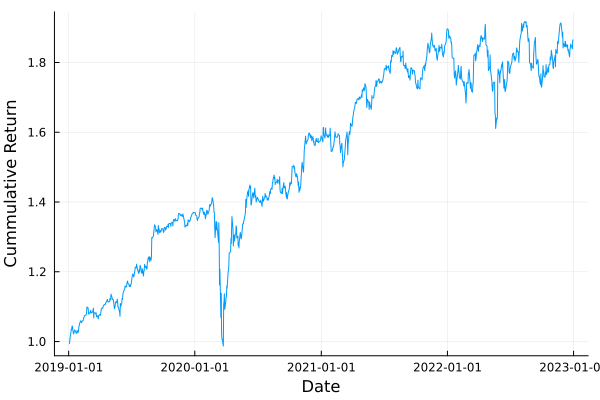

In [12]:
display(plot_returns(portfolio))

Plot the portfolio returns per asset.

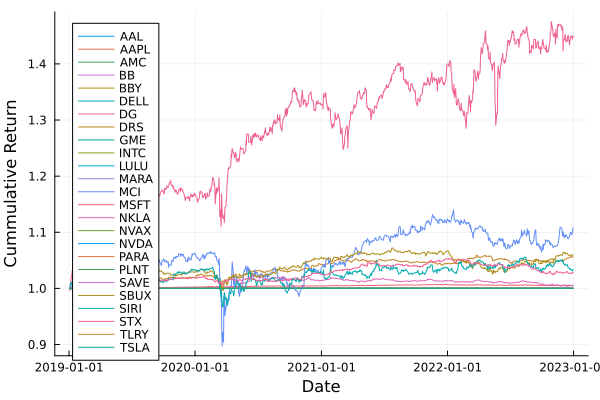

In [13]:
display(plot_returns(portfolio; per_asset = true))

Plot portfolio composition.

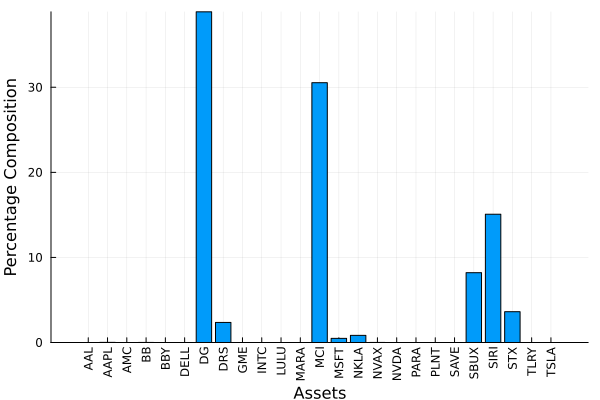

In [14]:
display(plot_bar(portfolio))

Plot the returns histogram.

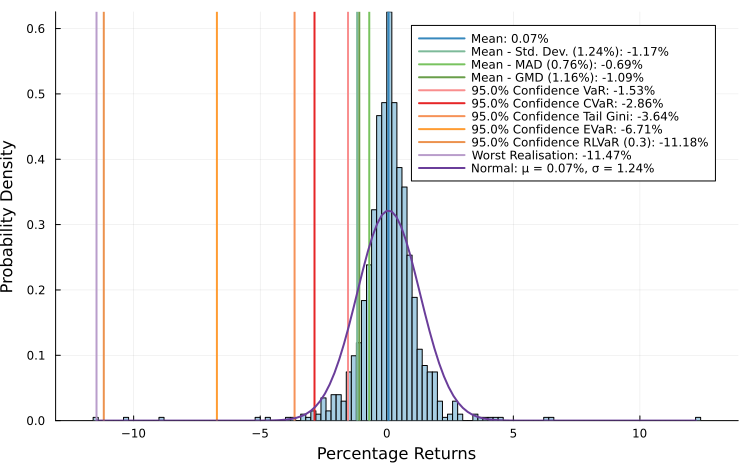

In [15]:
display(plot_hist(portfolio))

Plot the portfolio range of returns.

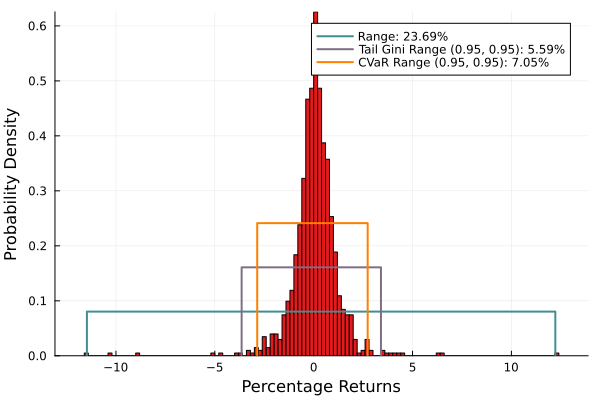

In [16]:
display(plot_range(portfolio))

Plot portfolio drawdown.

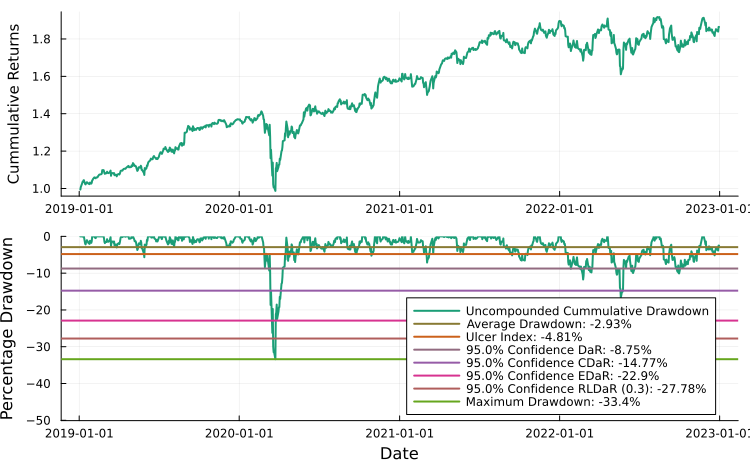

In [17]:
display(plot_drawdown(portfolio))

This is, however not our actual portfolio, it is the optimal one. To plot the allocated portfolio we need to know the key it is stored under and pass that on to the plotting functions along with a flag. The key is the symbol composed of the allocation method, in this case LP() and the portfolio type, which is something we have not discussed, but defaults to Trad(), as a Symbol.

In [18]:
# Side by side optimal portfolio vs allocated portfolio.
pretty_table(hcat(portfolio.optimal[:Trad],
                  DataFrames.rename!(portfolio.alloc_optimal[:LP_Trad][!, 2:end],
                                     Dict(:weights => :alloc_weights)),
                  DataFrame(;
                            weight_diff = portfolio.optimal[:Trad].weights -
                                          portfolio.alloc_optimal[:LP_Trad].weights));
             formatters = fmt3)

┌─────────┬──────────┬────────┬─────────┬─────────┬───────────────┬─────────────┐
│ tickers │  weights │ shares │   price │    cost │ alloc_weights │ weight_diff │
│  String │  Float64 │  Int64 │ Float64 │ Float64 │       Float64 │     Float64 │
├─────────┼──────────┼────────┼─────────┼─────────┼───────────────┼─────────────┤
│     AAL │    0.0 % │      0 │   12.72 │     0.0 │         0.0 % │       0.0 % │
│    AAPL │  0.014 % │      0 │ 128.719 │     0.0 │         0.0 % │     0.014 % │
│     AMC │    0.0 % │      0 │    40.7 │     0.0 │         0.0 % │       0.0 % │
│      BB │  0.003 % │      0 │    3.26 │     0.0 │         0.0 % │     0.003 % │
│     BBY │    0.0 % │      0 │ 74.6868 │     0.0 │         0.0 % │       0.0 % │
│    DELL │  0.001 % │      0 │ 38.6021 │     0.0 │         0.0 % │     0.001 % │
│      DG │  38.87 % │      2 │ 240.305 │  480.61 │      48.061 % │    -9.192 % │
│     DRS │  2.359 % │      1 │   12.78 │   12.78 │       1.278 % │     1.081 % │
│     GME │    0

Plot the portfolio returns.

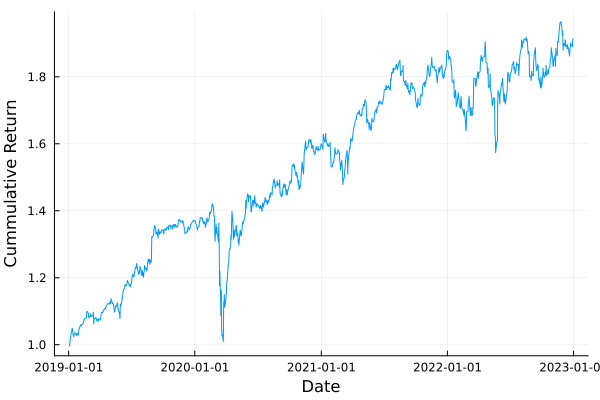

In [19]:
display(plot_returns(portfolio, :LP_Trad; allocated = true))

Plot the portfolio returns per asset.

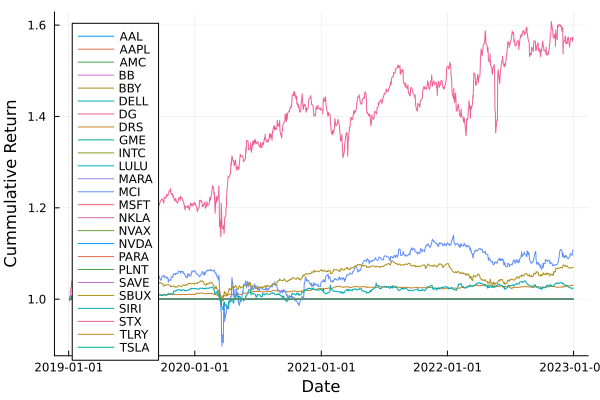

In [20]:
display(plot_returns(portfolio, :LP_Trad; allocated = true, per_asset = true))

Plot portfolio composition.

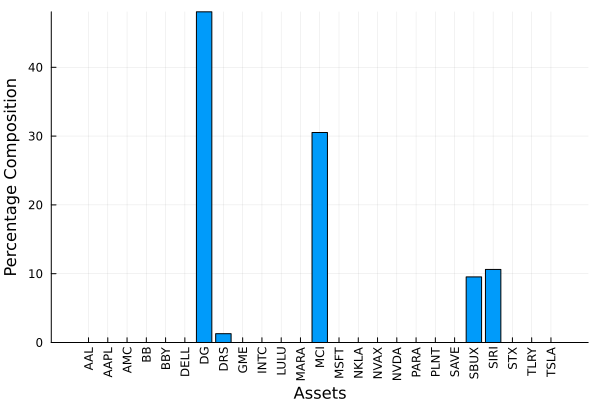

In [21]:
display(plot_bar(portfolio, :LP_Trad; allocated = true))

Plot the returns histogram.

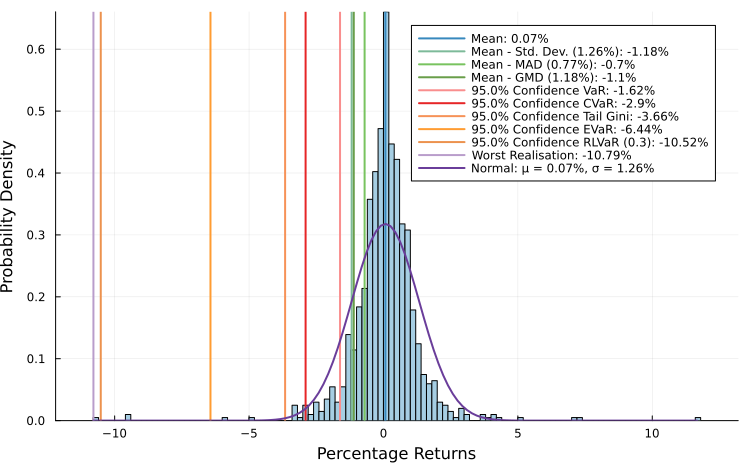

In [22]:
display(plot_hist(portfolio, :LP_Trad; allocated = true))

Plot the portfolio range of returns.

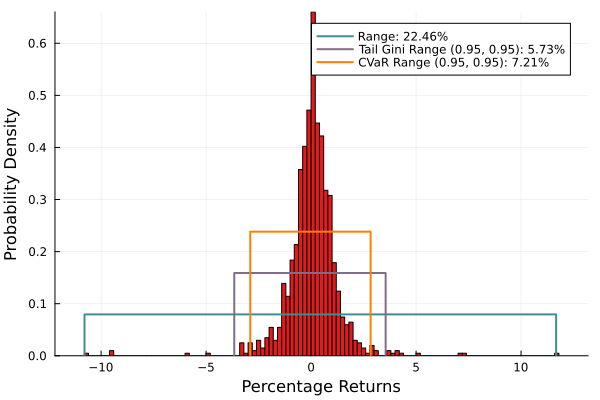

In [23]:
display(plot_range(portfolio, :LP_Trad; allocated = true))

Plot portfolio drawdown.

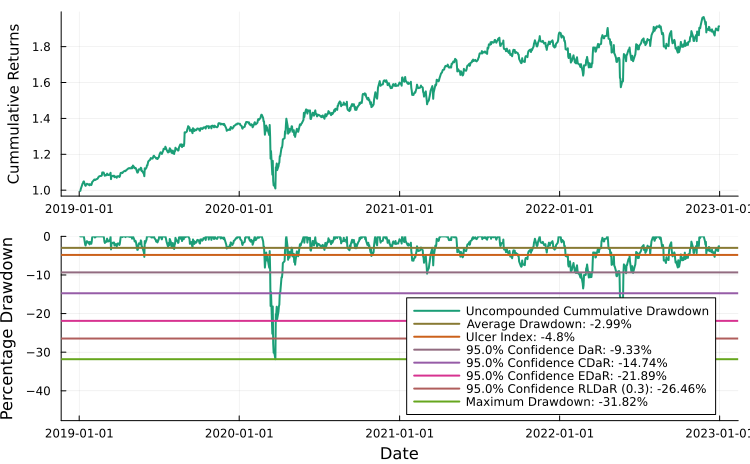

In [24]:
display(plot_drawdown(portfolio, :LP_Trad; allocated = true))

## 7. Efficient frontier

We have seen how you can optimise a single portfolio, but in reality there are an infinite number of optimal portfolios which exist along what is called the efficient frontier. We can compute and view this frontier, as well as viewing its composition very easily using [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl).

The idea is to first compute the minimum risk and maximum return portfolios. From these we generate a range of risks and returns. We then loop over all these values. At each step we maximise the expected return whilst constraining the risk to be lower than or equal to current risk value in the range of risks. If an optimisation fails, we instead minimise the risk whilst constraining the expected return to be bigger than or equal to the corresponding value in the range of expected returns. We save the results for each step. We can then use these to plot the efficient frontier and its composition at each point.

In [25]:
# Compute 50 points in the efficient frontier.
points = 50
frontier = efficient_frontier!(portfolio; rm = rm, points = points)

Dict{Symbol, Any} with 3 entries:
  :sharpe  => true
  :weights => 25×52 DataFrame…
  :risks   => [0.0124067, 0.0142085, 0.0160102, 0.0178119, 0.0196136, 0.0214154…

Plot the efficient frontier.

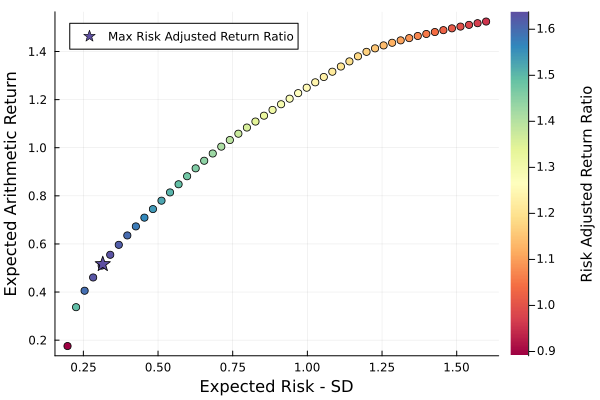

In [26]:
display(plot_frontier(portfolio; rm = rm))

Plot frontier asset composition.

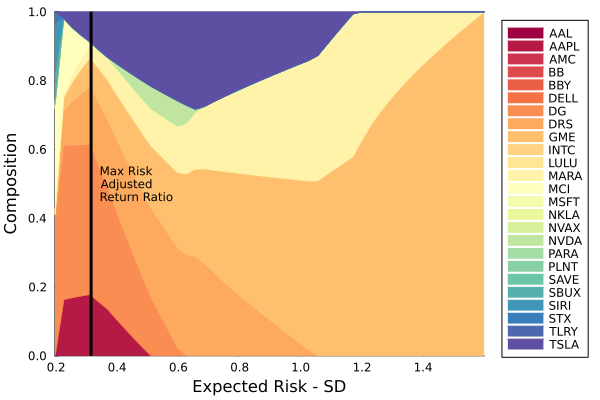

In [27]:
display(plot_frontier_area(portfolio; rm = rm))

The efficient frontier is outputted by `efficient_frontier!`, but also saves it in the `portfolio` instance. It is a dictionary whose keys are the symbols of the risk measure used to compute the efficient frontier. We've only computed the efficient frontier for the SD, so we can access the efficient frontier data by indexing into the `:SD` key. The documentation for `Portfolio` contains more details.

As the last demo we will display a heatmap of the portfolio composition of the efficient frontier in `SD()`.

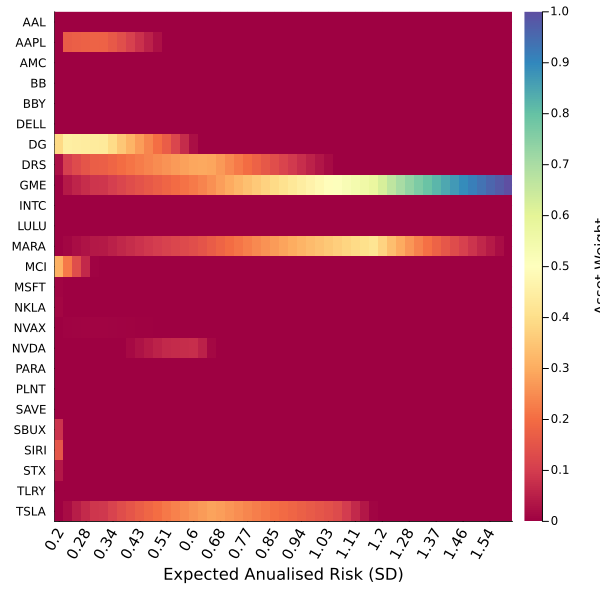

In [28]:
# Check if the sharpe ratio is found in the frontier.
if portfolio.frontier[:SD][:sharpe]
    risks = portfolio.frontier[:SD][:risks]
    weights = DataFrames.rename(portfolio.frontier[:SD][:weights],
                                Symbol.(1:length(risks)) .=>
                                    Symbol.(round.(risks * 100, digits = 2)))
    idx = sortperm(portfolio.frontier[:SD][:risks])
    weights = weights[!, [1; idx .+ 1]]
    risks = risks[idx]
else
    weights = Matrix(portfolio.frontier[:SD][:weights])
    risks = portfolio.frontier[:SD][:risks]
end

display(plot(Matrix(weights[!, 2:end]); st = :heatmap, clim = (0, 1),
             yticks = (1:N, portfolio.assets), yflip = true,
             xticks = (1:3:length(risks), round.(risks * sqrt(252), digits = 2)[1:3:end]),
             xrotation = 60, xtickfontsize = 10, xlabel = "Expected Anualised Risk (SD)",
             color = cgrad(:Spectral), size = (600, 600),
             colorbar_title = "\nAsset Weight"))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*